In [57]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:

# Download Shakespeare dataset
shakespeare_path = "shakespeare.txt"

# Read the content of the downloaded file
with open(shakespeare_path, "r", encoding="utf-8") as file:
    text = file.read()

# Display the first 500 characters of the text
print(text[:500])


That, poor contempt, or claim'd thou slept so faithful,
I may contrive our father; and, in their defeated queen,
Her flesh broke me and puttance of expedition house,
And in that same that ever I lament this stomach,
And he, nor Butly and my fury, knowing everything
Grew daily ever, his great strength and thought
The bright buds of mine own.

BIONDELLO:
Marry, that it may not pray their patience.'

KING LEAR:
The instant common maid, as we may less be
a brave gentleman and joiner: he that finds u


In [60]:
#text = text.lower()
text = text.strip()
text = text.replace("\n", " ")

#text_list  = [txt for txt in text]


In [61]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(text))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['_'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)


{0: '_',
 1: ' ',
 2: '!',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'c',
 39: 'd',
 40: 'e',
 41: 'f',
 42: 'g',
 43: 'h',
 44: 'i',
 45: 'j',
 46: 'k',
 47: 'l',
 48: 'm',
 49: 'n',
 50: 'o',
 51: 'p',
 52: 'q',
 53: 'r',
 54: 's',
 55: 't',
 56: 'u',
 57: 'v',
 58: 'w',
 59: 'x',
 60: 'y',
 61: 'z'}


In [62]:
print(text[0:500])

That, poor contempt, or claim'd thou slept so faithful, I may contrive our father; and, in their defeated queen, Her flesh broke me and puttance of expedition house, And in that same that ever I lament this stomach, And he, nor Butly and my fury, knowing everything Grew daily ever, his great strength and thought The bright buds of mine own.  BIONDELLO: Marry, that it may not pray their patience.'  KING LEAR: The instant common maid, as we may less be a brave gentleman and joiner: he that finds u


In [63]:
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
context = [0] * block_size
for i in range(0, len(text)-10, block_size-1):
  #context = [0] * block_size
  for ch in text[i:i+block_size-1]:
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

_____ ---> T
____T ---> h
___Th ---> a
__Tha ---> t
_That ---> ,
That, --->  
hat,  ---> p
at, p ---> o
t, po ---> o
, poo ---> r
 poor --->  
poor  ---> c
oor c ---> o
or co ---> n
r con ---> t
 cont ---> e
conte ---> m
ontem ---> p
ntemp ---> t
tempt ---> ,
empt, --->  
mpt,  ---> o
pt, o ---> r
t, or --->  
, or  ---> c
 or c ---> l
or cl ---> a
r cla ---> i
 clai ---> m
claim ---> '
laim' ---> d
aim'd --->  
im'd  ---> t
m'd t ---> h
'd th ---> o
d tho ---> u
 thou --->  
thou  ---> s
hou s ---> l
ou sl ---> e
u sle ---> p
 slep ---> t
slept --->  
lept  ---> s
ept s ---> o
pt so --->  
t so  ---> f
 so f ---> a
so fa ---> i
o fai ---> t
 fait ---> h
faith ---> f
aithf ---> u
ithfu ---> l
thful ---> ,
hful, --->  
ful,  ---> I
ul, I --->  
l, I  ---> m
, I m ---> a
 I ma ---> y
I may --->  
 may  ---> c
may c ---> o
ay co ---> n
y con ---> t
 cont ---> r
contr ---> i
ontri ---> v
ntriv ---> e
trive --->  
rive  ---> o
ive o ---> u
ve ou ---> r
e our --->  
 our  ---> f
our f ---> a

In [64]:
# Embedding layer for the context

emb_dim = 5
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [65]:
emb.weight

Parameter containing:
tensor([[ 9.8948e-01, -3.0797e-01,  8.8105e-01,  2.2745e-01,  2.4862e+00],
        [ 2.6663e-01, -1.2887e+00,  3.4430e-01, -4.9916e-01,  2.0926e-01],
        [-1.3437e+00,  8.4758e-01, -1.0562e+00, -6.4020e-01, -3.5522e-02],
        [-6.6391e-01, -9.7750e-01,  7.6361e-01,  4.9480e-01, -2.9339e-02],
        [-6.5705e-01,  8.8990e-01,  5.5601e-01,  8.6365e-01, -1.1615e-01],
        [-1.0017e+00,  7.5403e-01,  1.3632e+00, -9.0681e-01, -9.5321e-03],
        [-8.8435e-01,  1.2264e+00, -1.6434e+00,  5.8709e-01, -8.5205e-01],
        [ 5.7265e-01,  6.0509e-01, -7.8013e-01, -5.8411e-01,  4.9593e-01],
        [-5.0420e-03,  8.4010e-01, -1.1270e+00,  1.3088e+00, -9.2769e-01],
        [ 1.3665e+00,  1.2960e+00,  2.6978e+00,  5.8627e-01,  6.5305e-01],
        [-6.1049e-02,  7.3594e-02,  1.8393e+00, -1.5870e-01,  5.5156e-01],
        [ 5.6579e-01,  7.0563e-01, -4.6784e-01, -4.2319e-01,  7.5876e-01],
        [ 1.5901e-01, -1.1364e+00,  1.1727e+00,  1.8295e-01, -9.7809e-01],
   

In [66]:
emb.weight.shape

torch.Size([62, 5])

<Axes: >

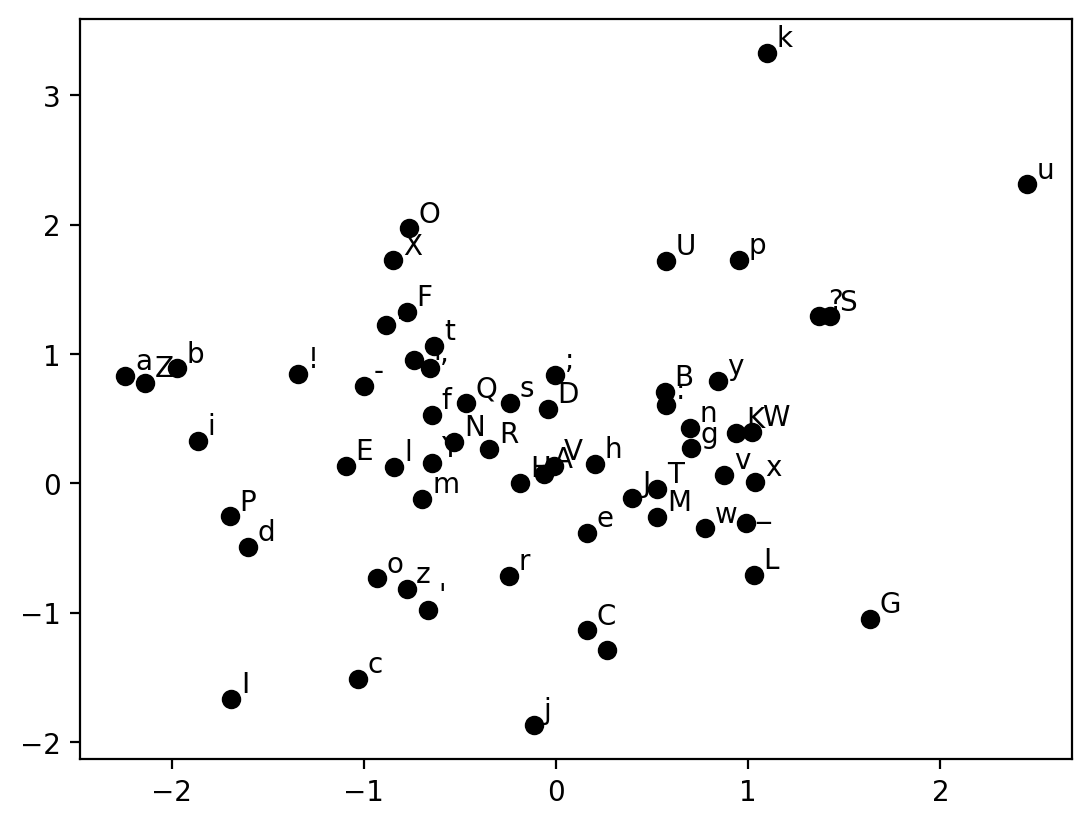

In [67]:

# Create itos (index to string) mapping
"""
itos = [None] * (max(stoi.values()) + 2)
for char, index in stoi.items():
    itos[index] = char
"""
# Function to visualize the embedding in 2d space
def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        values = emb.weight[i].detach().cpu().numpy()
        x, y = values[:2]  # Select the first two values for visualization
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax
plot_emb(emb, itos)

In [68]:

def plot_emb(emb, itos, ax = None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
          ax.set_title("2D Embeddings Before Training")
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
          ax.set_title("2D Embeddings using t-SNE After Training")
    return ax



In [69]:

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
import warnings


In [71]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x


In [73]:
# Predicting next k character from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
#model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '_':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

kvMPWFJfmZ
VqHe?dEah?
pCezPpel-s
Sv.FwCNVYy
PypFj-W;xf
VFDRbZAvdH
gZdOQ,D;uH
o-.MgUCfHz
sCpMoVAyRL
utFTEiL'uE


In [74]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

#(4096x60 and 100x10)

emb.weight torch.Size([62, 5])
lin1.weight torch.Size([10, 25])
lin1.bias torch.Size([10])
lin2.weight torch.Size([62, 10])
lin2.bias torch.Size([62])


In [75]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 3.1801788806915283
100 2.150379180908203


KeyboardInterrupt: 

<Axes: title={'center': '2D Embeddings using t-SNE After Training'}>

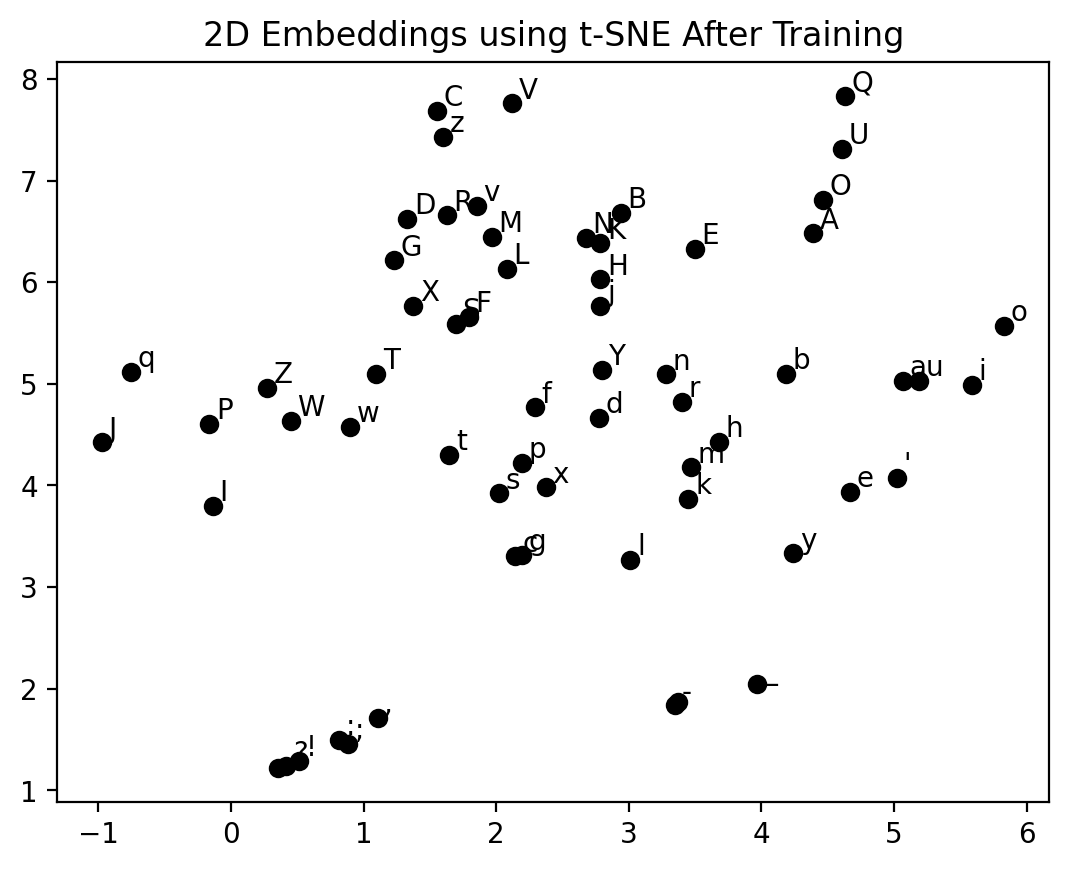

In [76]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [77]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

Bneas.  IA
Tha thaus 
: Ble sper
urt. Whest
Bre.  Fall
Haind ho w
Se sey you
S URNGIIF 
hale, pore
Flexe hen 


In [94]:

model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
#model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)

def generate_text(model, input_text,   itos, stoi, block_size,  length =100):
    context = [0] * block_size
    user_input_indices = [stoi[ch] for ch in input_text]

    if(len(user_input_indices)>block_size):
        context = user_input_indices[-block_size:]
    else:
        context[block_size-len(input_text):] = user_input_indices
    text = ''
    #context = [0]*block_size
    for i in range(length):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]

        if ch == "_":
            break 
        text += ch 
        context = context[1:] + [ix]
    return text

In [97]:
# User input
user_input = "till he shall fail his sister; and in true"
user_input_indices = [stoi[ch] for ch in user_input]

#context = torch.tensor(user_input_indices[-block_size:]).view(1, -1).to(device)
#x = torch.tensor(context).view(1, -1).to(device)
length = 30  # Change k to your desired value
predicted_characters = generate_text(model, user_input,  itos, stoi, block_size,  length )
print("pridected text: ", predicted_characters)



pridected text:  pCDZ!yopfQWgYPXh:EG,;LXMeXGh:s
